# Density Tree for N-dimensional data and labels
The code below implements a **density** tree for non-labelled data.

## Libraries
First, some libraries are loaded and global figure settings are made for exporting.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from IPython.core.display import Image, display

# Custom Libraries
from density_tree.density_tree_create import *
from density_tree.density_tree_traverse import *
from density_tree.create_data import *
from density_tree.helpers import *
from density_tree.plots import *

# Generic Functions
The methods implemented for producing a decision tree can be found in the python files under the package `density_tree`.


# Unsupervised entropy with unlabelled clusters
Below are some functions that compute an optimal split for unlabelled data, using the differential entropy of a d-variate Gaussian density. 

First, let's generate some unlabelled data:


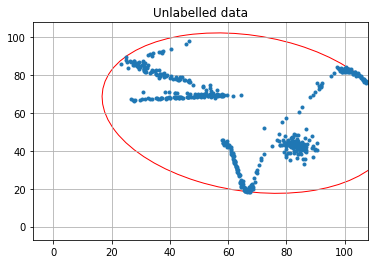

In [2]:
dimensions = 2
nclusters = 5
covariance = 10
npoints = 100
minRange = 10
maxRange = 100

dataset = create_data(nclusters, dimensions, covariance, npoints, minrange=minRange, maxrange=maxRange,
                      labelled=False, random_flip=True, nonlinearities=True)

dataset.shape

m = np.mean(dataset, axis=0)
cov = np.cov(dataset.T)

if dimensions == 2:
    figure, axes = plt.subplots(nrows=1, ncols=1)
    plot_data(dataset, "Unlabelled data", axes, labels=False, covs=[cov], means=[m])
    plt.show()

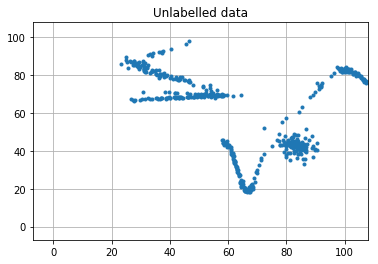

In [3]:
if dimensions == 2:
    figure, axes = plt.subplots(nrows=1, ncols=1)
    plot_data(dataset, "Unlabelled data", axes, labels=False)
    plt.show()

#### Create single Density Tree

In [4]:
root = create_density_tree(dataset, dimensions=dimensions, clusters=nclusters)

Creating new node
13.1118184819
Creating new node
11.7503412584
Creating new node


/Users/cyrilwendl/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:1110: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
/Users/cyrilwendl/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:73: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)
/Users/cyrilwendl/Documents/EPFL/SIE-Project/Code/density_tree/helpers.py:23: RuntimeWarning: Degrees of freedom <= 0 for slice
  k = np.linalg.det(np.cov(dataset.T))
/Users/cyrilwendl/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3093: RuntimeWarning: divide by zero encountered in double_scalars
  c *= 1. / np.float64(fact)
/Users/cyrilwendl/anaconda3/lib/python3.6/site-packages/numpy/lib/function_base.py:3093: RuntimeWarning: invalid value encountered in multiply
  c *= 1. / np.float64(fact)
/Users/cyrilwendl/anaconda3/lib/python3.6/site-packages/numpy/linalg/linalg.py:1804: RuntimeWarning: invalid value encountered in det
  r = 

10.9964507759
Creating new node


In [5]:
def get_values_preorder(node, cut_dims, cut_vals):
    cut_dims.append(node.split_dimension)
    cut_vals.append(node.split_value)
    if node.left is not None:
        get_values_preorder(node.left, cut_dims, cut_vals)
    if node.right is not None:
        get_values_preorder(node.right, cut_dims, cut_vals)
    return cut_vals, cut_dims

cut_vals, cut_dims = get_values_preorder(root, [], [])
cut_vals = np.asarray(cut_vals).astype(float)
cut_dims = np.asarray(cut_dims).astype(int)

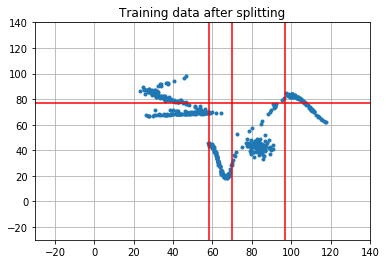

In [6]:
x_split = cut_vals[cut_dims == 0]
y_split = cut_vals[cut_dims == 1]

if dimensions == 2:
    fig, ax = plt.subplots(1, 1)
    plot_data(dataset, "Training data after splitting", ax, labels=False, lines_x=x_split, lines_y=y_split,
              minrange=minRange, maxrange=maxRange, covariance=covariance)

    %clear
    plt.show()

In [7]:
print(cut_dims, cut_vals)

[0 1 0 0] [ 58.36224287  76.91920455  96.6303233   69.88504355]


# Printing the Tree

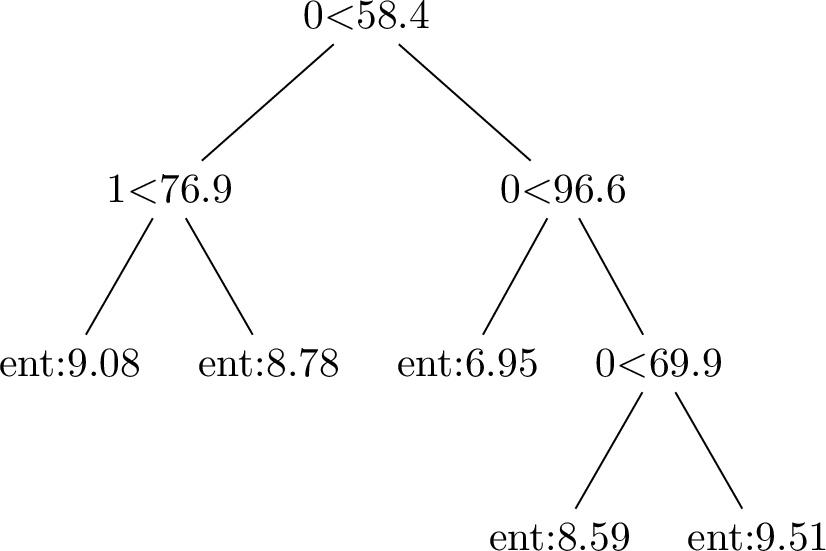

In [8]:
def tree_visualize(root):
    tree_string = ""
    tree_string = print_density_tree_latex(root, tree_string)
    
    os.system("cd figures; rm main.tex; more main_pt1.tex >> main.tex; echo '' >> main.tex;")
    os.system("cd figures; echo '" + tree_string + "' >> main.tex;  more main_pt2.tex >> main.tex;")
    os.system("cd figures; /Library/TeX/texbin/pdflatex main.tex; convert -density 300 -trim main.pdf -quality 100 main.png")
    display(Image('./figures/main.png', retina=True))
    
tree_visualize(root)

#### Showing all Clusters Covariances

In [9]:
covs, means = get_clusters(root, [], [])

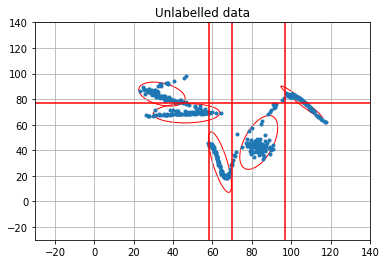

[0 1 0 0] [ 58.36224287  76.91920455  96.6303233   69.88504355]


In [10]:
if dimensions == 2:
    figure, axes = plt.subplots(nrows=1, ncols=1)
    plot_data(dataset, "Unlabelled data", axes, labels=False, covs=covs, means=means, lines_x=x_split, lines_y=y_split, 
                                minrange = minRange, maxrange = maxRange, covariance=covariance)
    plt.show()
    print(cut_dims, cut_vals)

#### Descent tree (predict "label")

In [11]:
from scipy.stats import multivariate_normal as multivariate_normal
multivariate_normal.pdf([20,70],means[0],covs[0])

2.9180682508466984e-05

In [12]:
# for all points 
probas = []
probas_other = []
for d in dataset:
    # descend tree
    d_mean, d_cov = descend_density_tree(d,root)

    # probability for this point to be from this distribution
    probas.append(multivariate_normal.pdf(d, d_mean, d_cov)*100)
    for i in range(5):
        probas_other.append(multivariate_normal.pdf(d, d_mean, covs[i])*100)
    
print("Probability to come from the leaf node cluster: %.2f%%" % np.mean(probas))
print("Probability to come from an arbitrary cluster: %.2f%%" % np.mean(probas_other))

Probability to come from the leaf node cluster: 0.44%
Probability to come from an arbitrary cluster: 0.27%


#### Create Density Forest